In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability.python.distributions as tfd

In [3]:
archs = np.array([[-1,-1],
                  [2,-2],
                  [0,0]])

In [4]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y0/np.max(Y1)
    Y2=Y0/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

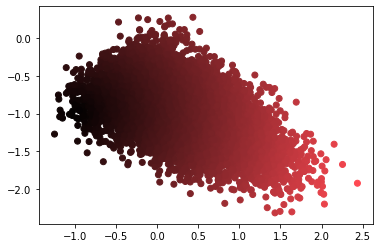

In [5]:
x_train, y_train = generate_data (archs,10000,noise=0.2)
x_test, y_test = generate_data (archs,1000,noise=0.2)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)

In [6]:
def get_zfixed ( dim_latent_space ):
    
    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                    
    return z_fixed


In [7]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
y_train = np.reshape(y_train, [-1, sideinfo_dim])
y_test = np.reshape(y_test, [-1, sideinfo_dim])


# network parameters
intermediate_dim = 64
batch_size = 1024
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 100


# encoder
input_x = tfk.Input(shape=(original_dim,), name='encoder_input_x')

x = tfkl.Dense(intermediate_dim, activation='relu')(input_x)
x = tfkl.Dense(intermediate_dim, activation='relu')(x)

A = tfkl.Dense (simplex_vrtxs, activation=tf.nn.softmax)(x)
B_t = tfkl.Dense (simplex_vrtxs, activation='linear')(x)
B = tf.nn.softmax(tf.transpose(B_t), axis=1)

z_fixed = get_zfixed (latent_dim)
z_fixed = tf.constant (z_fixed, dtype='float32')
mu = tf.matmul(A, z_fixed)
z_pred = tf.matmul(B,mu)
sigma = tfkl.Dense(latent_dim)(x)
t = tfd.Normal(mu,sigma)

input_y = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y')
y = tf.identity(input_y)

encoder = tfk.Model([input_x,input_y], [t.sample(),mu,sigma,y], name='encoder')
encoder.summary()


# decoder
latent_inputs = tfk.Input(shape=(latent_dim,), name='z_sampling')
input_y_lat = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y_lat')

x = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = tfkl.Dense(intermediate_dim, activation='relu')(x)
x_hat = tfkl.Dense(original_dim, activation='linear')(x)

y = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
y = tfkl.Dense(intermediate_dim, activation='relu')(y)
y_hat = tfkl.Dense(sideinfo_dim, activation='linear')(y) 

decoder = tfk.Model([latent_inputs,input_y_lat], [x_hat,y_hat], name='decoder')
decoder.summary()


# # VAE
encoded = encoder([input_x,input_y])
outputs = decoder( [encoded[0],encoded[-1]])
vae = tfk.Model([input_x,input_y], outputs, name='vae')


reconstruction_loss = tfk.losses.mse (input_x, outputs[0])
class_loss = tfk.losses.mse ( input_y, outputs[1])
archetype_loss = tf.reduce_sum( tfk.losses.mse(z_fixed, z_pred))

kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5

lambda_p = 1
nu_p = 10

vae_loss = tf.reduce_mean(nu_p*reconstruction_loss + lambda_p*class_loss + kl_loss + archetype_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


vae.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           192         encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            195         dense_1[0][0]                    
____________________________________________________________________________________________

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 2s 161us/sample - loss: 8.4923 - val_loss: 7.4008
Epoch 2/100
10000/10000 [==============================] - 0s 17us/sample - loss: 6.2361 - val_loss: 4.8072
Epoch 3/100
10000/10000 [==============================] - 0s 18us/sample - loss: 4.4236 - val_loss: 4.1542
Epoch 4/100
10000/10000 [==============================] - 0s 17us/sample - loss: 3.9062 - val_loss: 3.6919
Epoch 5/100
10000/10000 [==============================] - 0s 19us/sample - loss: 3.4960 - val_loss: 3.3771
Epoch 6/100
10000/10000 [==============================] - 0s 21us/sample - loss: 3.2069 - val_loss: 3.0787
Epoch 7/100
10000/10000 [==============================] - 0s 20us/sample - loss: 3.0168 - val_loss: 2.8891
Epoch 8/100
10000/10000 [==============================] - 0s 18us/sample - loss: 2.7041 - val_loss: 2.5481
Epoch 9/100
10000/10000 [==============================] - 0s 26us/sample - loss: 2.25

Epoch 76/100
10000/10000 [==============================] - 0s 14us/sample - loss: 0.0799 - val_loss: 0.0773
Epoch 77/100
10000/10000 [==============================] - 0s 17us/sample - loss: 0.0808 - val_loss: 0.0762
Epoch 78/100
10000/10000 [==============================] - 0s 15us/sample - loss: 0.0788 - val_loss: 0.0767
Epoch 79/100
10000/10000 [==============================] - 0s 16us/sample - loss: 0.0788 - val_loss: 0.0773
Epoch 80/100
10000/10000 [==============================] - 0s 19us/sample - loss: 0.0790 - val_loss: 0.0744
Epoch 81/100
10000/10000 [==============================] - 0s 26us/sample - loss: 0.0807 - val_loss: 0.0748
Epoch 82/100
10000/10000 [==============================] - 0s 30us/sample - loss: 0.0782 - val_loss: 0.0737
Epoch 83/100
10000/10000 [==============================] - 0s 19us/sample - loss: 0.0781 - val_loss: 0.0741
Epoch 84/100
10000/10000 [==============================] - 0s 25us/sample - loss: 0.0841 - val_loss: 0.0752
Epoch 85/100
10000/

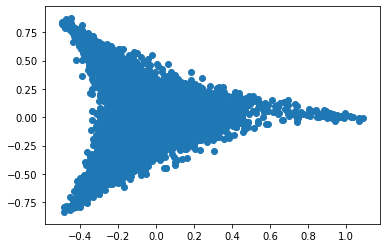

In [8]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[0].T
plt.scatter(dataX,dataY)


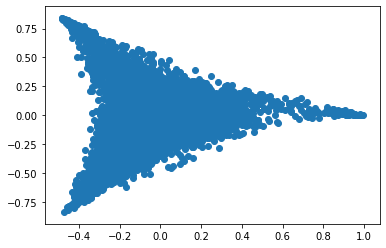

In [9]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[1].T
plt.scatter(dataX,dataY)


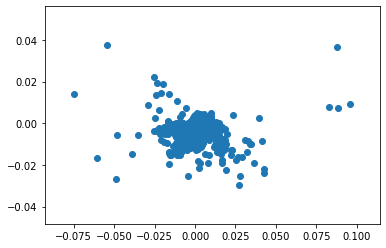

In [10]:
x_pred = encoder.predict([x_train,y_train])
dataX,dataY = x_pred[2].T
plt.scatter(dataX,dataY)


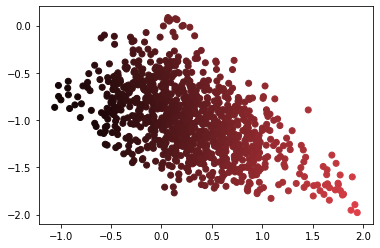

In [11]:
pred = vae.predict([x_test,y_test])
x_pred = pred[0]
y_pred = pred[1]
dataX,dataY = x_pred.T

if (np.min(y_pred)<0):
    y_pred += np.abs(np.min(y_pred))
if (np.min(y_pred)>1):
    y_pred /= np.max(y_pred)

plt.scatter(dataX,dataY,color=y_pred)

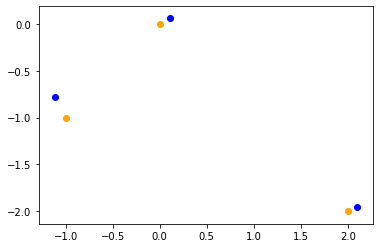

In [12]:
pred = decoder.predict([get_zfixed(2),np.zeros([3,3])]) 
x_pred = pred[0]
dataX,dataY = x_pred.T
plt.scatter(dataX,dataY,color='blue')
dataX,dataY = archs.T
plt.scatter(dataX,dataY,color='orange')